## **Instalación de paquetes**

In [1]:
# Extensión geoespacial para xarray
!pip install rioxarray

# Herramientas para scikit-learn con datos espaciales
!pip install pyimpute

# Proyecciones de mapas en matplotlib
!python -m pip install basemap

# Cuadrículas hexagonales para mapas
!pip install geohexgrid

# Barra de escala en matplotlib
!pip install matplotlib-scalebar

# Instalar mapas base
!pip3 install contextily

# Una vez instalados los paquetes anteriores, reinician la sesión y ejecutan de
# nuevo la celda

In [2]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 11), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 21.37 KiB | 3.05 MiB/s, done.
Resolving deltas: 100% (11/11), done.


## **Carga de Librerías**

In [3]:
import os                                                                       # manejo de directorios
from glob import glob                                                           # manejo de archivos
import contextily as cx                                                         # mapas base
import geopandas as gpd                                                         # manejo de archivos shapefile
import matplotlib.colors as colors                                              # personalización de colores
import matplotlib.pyplot as plt                                                 # gráficos
import matplotlib.font_manager as fm                                            # fuentes personalizadas
import numpy as np                                                              # manejo de arrays
import pandas as pd                                                             # manejo de datos estructurados
import xarray as xr                                                             # arrays multidimensionales etiquetados
import rasterio as rio                                                          # manejo de datos raster
import rioxarray as rxr                                                         # extensión para manejar raster con xarray
import seaborn as sns                                                           # gráficos estadísticos
import random                                                                   # para trabajar con números aleatorios (semilla)
from geopandas import GeoDataFrame                                              # creación de GeoDataFrames
from matplotlib.colors import ListedColormap                                    # mapas de colores personalizados
from matplotlib_scalebar.scalebar import ScaleBar                               # barra de escala en gráficos
from natsort import natsorted                                                   # ordenamiento natural de cadenas
from urllib.request import urlopen                                              # manejo de solicitudes (requests)
from io import BytesIO                                                          # manejo de archivos en memoria
from pandas import DataFrame                                                    # estructura de DataFrame en pandas
from rasterio.plot import show                                                  # visualización de datos raster
from matplotlib import colors, patches                                          # colores y formas en matplotlib
from shapely.geometry import mapping, Point, Polygon                            # geometrías para recortar rasters
from shapely import geometry                                                    # operaciones geométricas
from tqdm import tqdm                                                           # seguimiento de progreso
from urllib.error import HTTPError                                              # manejo de errores de HTTP
from warnings import simplefilter                                               # eliminación de advertencias
from weather_data_preprocessing import null_report                              # reporte de datos meteorológicos nulos
from zipfile import ZipFile                                                     # manejo de archivos .zip
from google.colab import files, drive                                           # Manejo de archivos en Google Colab

# PAQUETES PARA LA ETAPA DE ML (Machine Learning)
from sklearn import model_selection                                             # selección de modelos

from sklearn.preprocessing import OneHotEncoder                                 # codificación de datos categóricos
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV # dividir datos y validación cruzada
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # métricas de evaluación
from sklearn.pipeline import Pipeline                                           # creación de pipelines de ML

from sklearn.linear_model import LogisticRegression                             # regresión logística
from sklearn.ensemble import RandomForestClassifier  # Import the required module
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
drive.mount('/content/drive')                   # Acceso a archivos de Google Drive en Colab

Mounted at /content/drive


In [5]:
# Configuración de gráficos
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
simplefilter("ignore")

## **Carga de Funciones**

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

In [7]:
# Definición de ruta para almacenar figuras y/o datos para generarlas
ruta_figs = '/content/drive/MyDrive/Proyecto aplicado /figuras_matrices_confusion/VU/'

# **Carga de Datos: Vulnerable (VU)**



In [8]:
# Se cargan los datos del GeoDataFrame
path = "/content/drive/MyDrive/Proyecto aplicado /datos_unidos_avist_wc_mb_ant_vu/datos_unidos_avist_wc_mb_ant_vu.shp"

# Se cargan los datos del GeoDataFrame Juan
# path = "/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_wc_mb_ant_vu/datos_unidos_avist_wc_mb_ant_vu.shp"

gdf_mb_ev_elv_wc_vu = gpd.read_file(path)

In [9]:
# Se cargan las descripciones de MapBiomas Colombia
path = "/content/drive/MyDrive/Proyecto aplicado /mapbiomas_legends/colombia_legend_code_col_1_dot_0.csv"

# Se cargan las descripciones de MapBiomas Colombia Juan
# path = "/content/drive/MyDrive/research/codes/Proyecto aplicado /mapbiomas_legends/colombia_legend_code_col_1_dot_0.csv"

df_mb_legends = pd.read_csv(path, delimiter=';')

In [10]:
# Se renombran las variables
keys = gdf_mb_ev_elv_wc_vu.columns.to_list()
values = ['cell_id','observation_count', 'effort_speed_kmph','effort_hours',
          'effort_distance_km','number_observers', 'label','elevation',
          'anual_mean_t', 'mean_diurnal_range','isothermality', 't_seasonality',
          'max_t_warmest_month', 'min_t_coldest_month', 't_annual_range',
          'mean_t_wettest_q', 'mean_t_driest_q','mean_t_warmest_q','mean_t_coldest_q',
          'annual_p', 'p_wettest_m','p_driest_m', 'p_seasonality', 'p_wettest_q',
          'p_driest_q', 'p_warmest_q', 'p_coldest_q','index_right', 'lulc_2014',
          'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018', 'lulc_2019',
          'lulc_2020', 'geometry']

gdf_mb_ev_elv_wc_vu.rename(columns=dict(zip(keys, values)),inplace=True)

In [11]:
# Se convierten las columnas que tomaron los datos como cadenas de caracteres a
# números
columnas_strings = ['elevation','anual_mean_t', 'mean_diurnal_range','isothermality',
                    't_seasonality', 'max_t_warmest_month', 'min_t_coldest_month',
                    't_annual_range', 'mean_t_wettest_q', 'mean_t_driest_q',
                    'mean_t_warmest_q','mean_t_coldest_q','annual_p', 'p_wettest_m',
                    'p_driest_m', 'p_seasonality', 'p_wettest_q','p_driest_q',
                    'p_warmest_q', 'p_coldest_q']

gdf_mb_ev_elv_wc_vu[columnas_strings] = gdf_mb_ev_elv_wc_vu[columnas_strings].astype(float)

# Se convierten las columnas de MapBiomas a enteros
columnas_ints = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
                 'lulc_2019', 'lulc_2020']

gdf_mb_ev_elv_wc_vu[columnas_ints] = gdf_mb_ev_elv_wc_vu[columnas_ints].astype(int)

In [12]:
df_mb_legends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   clases  26 non-null     object
 1   id      26 non-null     int64 
 2   hex     26 non-null     object
dtypes: int64(1), object(2)
memory usage: 756.0+ bytes


In [13]:
# Las variables de uso y cobertura de suelo son categóricas, por lo que conviene
# convertirlas a cadenas de texto y luego generar la codificación dummy. Primero
# a cadena de texto:
lulc_list = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
             'lulc_2019', 'lulc_2020']

for lulc_year in lulc_list:
    keys = list(gdf_mb_ev_elv_wc_vu[lulc_year].unique())
    values = df_mb_legends[df_mb_legends['id'].isin(keys)]['clases']
    gdf_mb_ev_elv_wc_vu[lulc_year].replace(dict(zip(keys,values)), inplace=True)

gdf_mb_ev_elv_wc_vu

,cell_id,observation_count,effort_speed_kmph,effort_hours,effort_distance_km,number_observers,label,elevation,anual_mean_t,mean_diurnal_range,...,p_coldest_q,index_right,lulc_2014,lulc_2015,lulc_2016,lulc_2017,lulc_2018,lulc_2019,lulc_2020,geometry
0,"-464,6240",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,967.0,0,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.8933 7.00063)
1,"-464,6242",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,967.0,1,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.89155 7.02506)
2,"-464,6244",0.0,1.250000,4.183333,5.00,3.0,0,71.0,28.192833,11.117667,...,968.0,2,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.89433 7.05521)
3,"-464,6246",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.192833,11.117667,...,968.0,3,manglar,manglar,manglar,manglar,manglar,manglar,manglar,POINT (-73.89736 7.07805)
4,"-465,6239",0.0,8.185726,8.633333,13.99,11.0,0,75.0,28.035999,10.820666,...,926.0,4,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.91399 6.98307)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7117,"-587,6303",0.0,0.000000,0.000000,0.00,0.0,0,4.0,27.132500,7.939667,...,828.0,7117,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,otra_formacion_natural_no_forestal,POINT (-77.09574 7.79475)
7118,"-587,6305",0.0,0.000000,0.000000,0.00,0.0,0,4.0,27.132500,7.939667,...,828.0,7118,no_observado,playas_dunas_bancos_de_arena,mineria,mosaico_de_agricultura_pasto,mosaico_de_agricultura_pasto,infraestructura_urbana,formacion_natural_no_forestal_inundable,POINT (-77.09588 7.81951)
7119,"-588,6302",0.0,1.140000,0.166667,0.19,3.0,0,3.0,27.167334,7.989333,...,864.0,7119,rio_lago_oceano,rio_lago_oceano,no_observado,rio_lago_oceano,rio_lago_oceano,rio_lago_oceano,no_observado,POINT (-77.11322 7.78612)
7120,"-588,6304",0.0,11.053846,0.383333,2.35,6.0,0,4.0,27.132500,7.939667,...,828.0,7120,bosque,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,otra_formacion_natural_no_forestal,POINT (-77.11676 7.80881)


In [14]:
count_ausencias = (gdf_mb_ev_elv_wc_vu['observation_count'] == 0.0).sum()

count_presencias = (gdf_mb_ev_elv_wc_vu['observation_count'] != 0.0).sum()

print(f'Cantidad de valores 0.0: {count_ausencias}')
print(f'Cantidad de valores diferentes a 0.0: {count_presencias}')

Cantidad de valores 0.0: 6926
Cantidad de valores diferentes a 0.0: 196


In [15]:
# Ahora los dummy para cada categoría de uso de suelo por año
gdf_mb_ev_elv_wc_vu = pd.concat([
    gdf_mb_ev_elv_wc_vu.drop(columns = lulc_list),
    pd.get_dummies(gdf_mb_ev_elv_wc_vu[lulc_list], dtype=float)
], axis = 1)

gdf_mb_ev_elv_wc_vu.head()

,cell_id,observation_count,effort_speed_kmph,effort_hours,effort_distance_km,number_observers,label,elevation,anual_mean_t,mean_diurnal_range,...,lulc_2020_infraestructura_urbana,lulc_2020_manglar,lulc_2020_mineria,lulc_2020_mosaico_de_agricultura_pasto,lulc_2020_no_observado,lulc_2020_otra_area_sin_vegetacion,lulc_2020_otra_formacion_natural_no_forestal,lulc_2020_palma_aceitera,lulc_2020_rio_lago_oceano,lulc_2020_silvicultura
0,"-464,6240",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"-464,6242",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"-464,6244",0.0,1.250000,4.183333,5.00,3.0,0,71.0,28.192833,11.117667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"-464,6246",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.192833,11.117667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"-465,6239",0.0,8.185726,8.633333,13.99,11.0,0,75.0,28.035999,10.820666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Declaremos las columnas que son únicamente numéricas
columnas_no_interes = ['cell_id','label','index_right']
variables_exogenas = gdf_mb_ev_elv_wc_vu.drop(columns=columnas_no_interes).columns.to_list()

## **Código Principal**

In [17]:
# Matriz de correlación
sns.heatmap(gdf_mb_ev_elv_wc_vu[variables_exogenas].drop(columns=['geometry','observation_count']).corr(numeric_only=True))

# Displaying heatmap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Crear figura y ejes explícitamente
fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño según lo que necesites

# Crear el heatmap
sns.heatmap(
    gdf_mb_ev_elv_wc_vu[variables_exogenas].drop(columns=['geometry', 'observation_count']).corr(numeric_only=True),
    ax=ax
)

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_22_matriz_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Se declara la X e y de nuestro problema
X = gdf_mb_ev_elv_wc_vu[variables_exogenas]
y = gdf_mb_ev_elv_wc_vu['label']

In [20]:
# Pipeline declaration
pipe_lr = Pipeline([('LR', LogisticRegression(random_state=42))]) # Regresión Logística
pipe_rf = Pipeline([('RF',RandomForestClassifier(random_state=42))]) # Random Forest

In [21]:
# Configuración de los hiper-parámetros del modelo
param_range_fl = [1.0, 0.5, 0.1]
param_range = [1, 2, 3, 4, 5, 6]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                  'LR__C': param_range_fl,
                  'LR__solver': ['liblinear']}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                  'RF__max_depth': param_range,
                  'RF__min_samples_split': param_range[1:]}]

In [22]:
# Configuración de validación cruzada

cv = 3
n_jobs = -1
verbose = 2
random_state = 42

lr_grid_search = RandomizedSearchCV(estimator=pipe_lr,
        param_distributions=lr_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

rf_grid_search = RandomizedSearchCV(estimator=pipe_rf,
        param_distributions=rf_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

### **Prueba sin tratar el desbalance de clases**

In [23]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [24]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(columns=['geometry','observation_count']), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 9.83 s, sys: 169 ms, total: 10 s
Wall time: 50.6 s


In [25]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1386
           1       1.00      0.13      0.23        39

    accuracy                           0.98      1425
   macro avg       0.99      0.56      0.61      1425
weighted avg       0.98      0.98      0.97      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 2, 'RF__min_samples_leaf': 6, 'RF__max_depth': 5}

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1386
           1       0.71      0.26      0.38        39

    accuracy                           0.98      1425
   macro avg       0.85      0.63      0.68      1425
weighted avg       0.97      0.98      0.97      1425



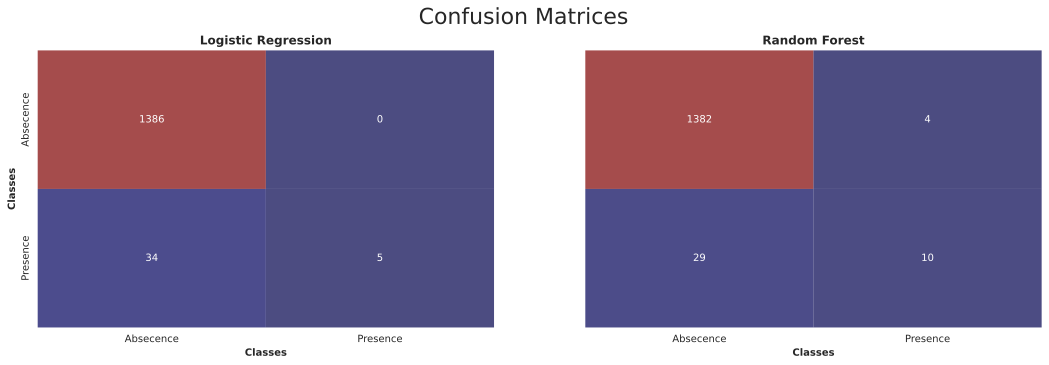

In [26]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Absecence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_37_VU_sin_balanceo_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [27]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr = final_model_lr.predict_proba(X.drop(['geometry','observation_count'],axis=1))
y_final_rf = final_model_rf.predict_proba(X.drop(['geometry','observation_count'],axis=1))


# Almacenamiento de la probabilidad asociada al modelo
X['lr_probability'] = y_final_lr[:,1]
X['rf_probability'] = y_final_rf[:,1]

In [28]:
# MAPS - PROBABILITY
fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(12,9))
axis[0].set_title('Logistic Regression Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[0], markersize=8, column='lr_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[0].add_artist(ScaleBar(1))
plt.grid(False)

axis[1].set_title('Random Forest Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[1], markersize=8, column='rf_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[1].add_artist(ScaleBar(1))
plt.grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_58_MAPA_VU_sin_balanceo_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
presencias_test = X_test[X_test['observation_count'] != 0.0]

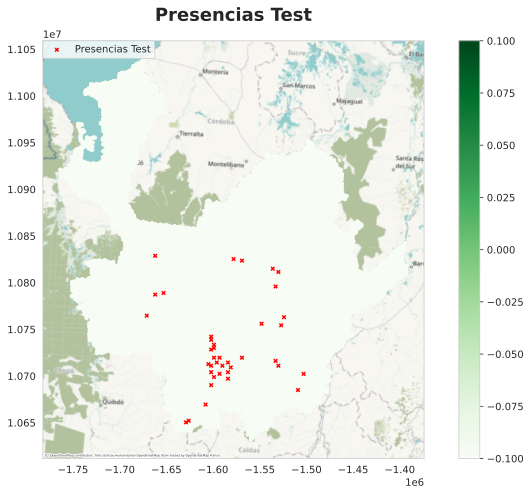

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

# Título del mapa
ax.set_title('Presencias Test', fontsize=18, fontweight='bold', pad=20)

# Graficar la probabilidad del Random Forest
X.to_crs(epsg=5382).plot(
    ax=ax,
    markersize=11,
    column='rf_probability',
    cmap='Greens',
    legend=True,
    vmin=0,
    vmax=0,
    #legend_kwds={'shrink': 0.6, 'aspect': 20}
)

# Graficar las presencias test
presencias_test.to_crs(epsg=5382).plot(
    ax=ax,
    marker='x',
    color='red',
    markersize=12.5,
    label='Presencias Test'
)

# Agregar el mapa base y la barra de escala
cx.add_basemap(ax=ax, crs=X.to_crs(epsg=5382).crs, attribution_size=3)
# ax.add_artist(ScaleBar(1))

# Configurar la leyenda y desactivar la cuadrícula
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), borderaxespad=0)
ax.grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_57_PRESENCIAS_MAPA_VU.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

### **Prueba balanceando clases: RandomOverSampler**

Los resultados anteriores pueden ser engañosos, por lo que convendría aplicar alguna técnica que permita lidiar con el desbalance de clases:

In [31]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [32]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [33]:
# Conversión a GeoDataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

In [34]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train_resampled.drop(columns=['geometry','observation_count','lr_probability','rf_probability']), y_train_resampled)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 34.1 s, sys: 589 ms, total: 34.7 s
Wall time: 2min 52s


In [35]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1386
           1       0.14      0.82      0.24        39

    accuracy                           0.86      1425
   macro avg       0.57      0.84      0.58      1425
weighted avg       0.97      0.86      0.90      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1386
           1       0.26      0.87      0.40        39

    accuracy                           0.93      1425
   macro avg       0.63      0.90      0.68      1425
weighted avg       0.98      0.93      0.95      1425



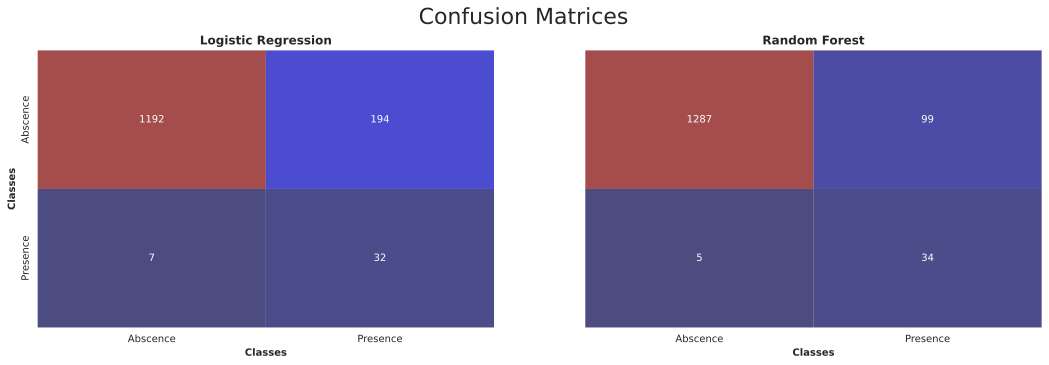

In [36]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search}
iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Abscence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_38_VU_balanceo_RandomOver_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [37]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr_ros = final_model_lr.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability'],axis=1))
y_final_rf_ros = final_model_rf.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['lr_ros_probability'] = y_final_lr_ros[:,1]
X['rf_ros_probability'] = y_final_rf_ros[:,1]

In [38]:
# MAPAS - PROBABILIDAD
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))  # Cambié ncols=1 a ncols=2 para crear dos subplots

# Primer subplot: Probabilidad del modelo de Regresión Logística
axis[0].set_title('LR Oversampling Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg=5382).plot(ax=axis[0], markersize=8, column='lr_ros_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0], crs=X.to_crs(epsg=5382).crs, attribution_size=3)
axis[0].add_artist(ScaleBar(1))
axis[0].grid(False)

# Segundo subplot: Probabilidad del modelo Random Forest
axis[1].set_title('RF Oversampling Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg=5382).plot(ax=axis[1], markersize=8, column='rf_ros_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1], crs=X.to_crs(epsg=5382).crs, attribution_size=3)
axis[1].add_artist(ScaleBar(1))
axis[1].grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_59_MAPA_VU_balanceo_RandomOver_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Prueba balanceando clases: SMOTE - Synthetic Minority Over-sampling Technique**

Otra alternativa para tratar el desbalance es usar la función SMOTE:

In [39]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.drop(columns=['geometry']), y_train)

In [41]:
# Conversión a GeoDataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.drop(columns=['geometry']).columns)

In [42]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train_resampled.drop(columns=['observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']), y_train_resampled)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 38.9 s, sys: 403 ms, total: 39.3 s
Wall time: 2min 48s


In [43]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 0.5}

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1386
           1       0.16      0.82      0.27        39

    accuracy                           0.88      1425
   macro avg       0.58      0.85      0.60      1425
weighted avg       0.97      0.88      0.92      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1386
           1       0.31      0.74      0.44        39

    accuracy                           0.95      1425
   macro avg       0.65      0.85      0.70      1425
weighted avg       0.97      0.95      0.96      1425



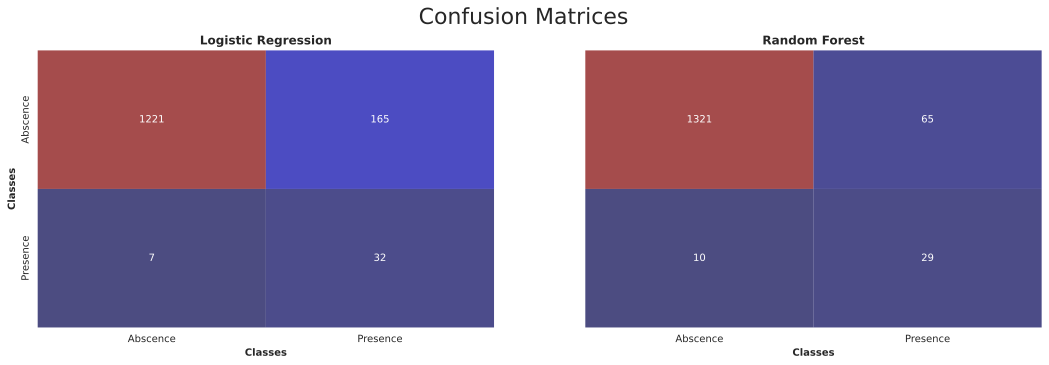

In [44]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search,}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Abscence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_39_VU_balanceo_SMOTE_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [45]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr_smote = final_model_lr.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability'],axis=1))
y_final_rf_smote = final_model_rf.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['lr_smote_probability'] = y_final_lr_smote[:,1]
X['rf_smote_probability'] = y_final_rf_smote[:,1]

In [46]:
# MAPS - PROBABILITY
fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(12,9))
axis[0].set_title('LR SMOTE Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[0], markersize=8, column='lr_smote_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[0].add_artist(ScaleBar(1))
plt.grid(False)

axis[1].set_title('RF SMOTE Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[1], markersize=8, column='rf_smote_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[1].add_artist(ScaleBar(1))
plt.grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_60_MAPA_VU_balanceo_SMOTE_sin_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **VIF: Vulnerable (VU)**

In [47]:
# Se cargan los datos del GeoDataFrame
path = "/content/drive/MyDrive/Proyecto aplicado /datos_unidos_avist_wc_mb_ant_vu/datos_unidos_avist_wc_mb_ant_vu.shp"

# Se cargan los datos del GeoDataFrame Juan
# path = "/content/drive/MyDrive/research/codes/Proyecto aplicado /datos_unidos_avist_wc_mb_ant_vu/datos_unidos_avist_wc_mb_ant_vu.shp"

gdf_mb_ev_elv_wc_vu = gpd.read_file(path)

In [48]:
# Se cargan las descripciones de MapBiomas Colombia
path = "/content/drive/MyDrive/Proyecto aplicado /mapbiomas_legends/colombia_legend_code_col_1_dot_0.csv"

# Se cargan las descripciones de MapBiomas Colombia Juan
# path = "/content/drive/MyDrive/research/codes/Proyecto aplicado /mapbiomas_legends/colombia_legend_code_col_1_dot_0.csv"

df_mb_legends = pd.read_csv(path, delimiter=';')

In [49]:
# Se renombran las variables
keys = gdf_mb_ev_elv_wc_vu.columns.to_list()
values = ['cell_id','observation_count', 'effort_speed_kmph','effort_hours',
          'effort_distance_km','number_observers', 'label','elevation',
          'anual_mean_t', 'mean_diurnal_range','isothermality', 't_seasonality',
          'max_t_warmest_month', 'min_t_coldest_month', 't_annual_range',
          'mean_t_wettest_q', 'mean_t_driest_q','mean_t_warmest_q','mean_t_coldest_q',
          'annual_p', 'p_wettest_m','p_driest_m', 'p_seasonality', 'p_wettest_q',
          'p_driest_q', 'p_warmest_q', 'p_coldest_q','index_right', 'lulc_2014',
          'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018', 'lulc_2019',
          'lulc_2020', 'geometry']

gdf_mb_ev_elv_wc_vu.rename(columns=dict(zip(keys, values)),inplace=True)

In [50]:
# Se convierten las columnas que tomaron los datos como cadenas de caracteres a
# números
columnas_strings = ['elevation','anual_mean_t', 'mean_diurnal_range','isothermality',
                    't_seasonality', 'max_t_warmest_month', 'min_t_coldest_month',
                    't_annual_range', 'mean_t_wettest_q', 'mean_t_driest_q',
                    'mean_t_warmest_q','mean_t_coldest_q','annual_p', 'p_wettest_m',
                    'p_driest_m', 'p_seasonality', 'p_wettest_q','p_driest_q',
                    'p_warmest_q', 'p_coldest_q']

gdf_mb_ev_elv_wc_vu[columnas_strings] = gdf_mb_ev_elv_wc_vu[columnas_strings].astype(float)

# Se convierten las columnas de MapBiomas a enteros
columnas_ints = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
                 'lulc_2019', 'lulc_2020']

gdf_mb_ev_elv_wc_vu[columnas_ints] = gdf_mb_ev_elv_wc_vu[columnas_ints].astype(int)

In [51]:
df_mb_legends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   clases  26 non-null     object
 1   id      26 non-null     int64 
 2   hex     26 non-null     object
dtypes: int64(1), object(2)
memory usage: 756.0+ bytes


In [52]:
# Las variables de uso y cobertura de suelo son categóricas, por lo que conviene
# convertirlas a cadenas de texto y luego generar la codificación dummy. Primero
# a cadena de texto:
lulc_list = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
             'lulc_2019', 'lulc_2020']

for lulc_year in lulc_list:
    keys = list(gdf_mb_ev_elv_wc_vu[lulc_year].unique())
    values = df_mb_legends[df_mb_legends['id'].isin(keys)]['clases']
    gdf_mb_ev_elv_wc_vu[lulc_year].replace(dict(zip(keys,values)), inplace=True)

gdf_mb_ev_elv_wc_vu

,cell_id,observation_count,effort_speed_kmph,effort_hours,effort_distance_km,number_observers,label,elevation,anual_mean_t,mean_diurnal_range,...,p_coldest_q,index_right,lulc_2014,lulc_2015,lulc_2016,lulc_2017,lulc_2018,lulc_2019,lulc_2020,geometry
0,"-464,6240",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,967.0,0,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.8933 7.00063)
1,"-464,6242",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,967.0,1,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.89155 7.02506)
2,"-464,6244",0.0,1.250000,4.183333,5.00,3.0,0,71.0,28.192833,11.117667,...,968.0,2,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.89433 7.05521)
3,"-464,6246",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.192833,11.117667,...,968.0,3,manglar,manglar,manglar,manglar,manglar,manglar,manglar,POINT (-73.89736 7.07805)
4,"-465,6239",0.0,8.185726,8.633333,13.99,11.0,0,75.0,28.035999,10.820666,...,926.0,4,bosque,bosque,bosque,bosque,bosque,bosque,bosque,POINT (-73.91399 6.98307)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7117,"-587,6303",0.0,0.000000,0.000000,0.00,0.0,0,4.0,27.132500,7.939667,...,828.0,7117,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,otra_formacion_natural_no_forestal,POINT (-77.09574 7.79475)
7118,"-587,6305",0.0,0.000000,0.000000,0.00,0.0,0,4.0,27.132500,7.939667,...,828.0,7118,no_observado,playas_dunas_bancos_de_arena,mineria,mosaico_de_agricultura_pasto,mosaico_de_agricultura_pasto,infraestructura_urbana,formacion_natural_no_forestal_inundable,POINT (-77.09588 7.81951)
7119,"-588,6302",0.0,1.140000,0.166667,0.19,3.0,0,3.0,27.167334,7.989333,...,864.0,7119,rio_lago_oceano,rio_lago_oceano,no_observado,rio_lago_oceano,rio_lago_oceano,rio_lago_oceano,no_observado,POINT (-77.11322 7.78612)
7120,"-588,6304",0.0,11.053846,0.383333,2.35,6.0,0,4.0,27.132500,7.939667,...,828.0,7120,bosque,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,formacion_natural_no_forestal_inundable,otra_formacion_natural_no_forestal,POINT (-77.11676 7.80881)


In [53]:
# Ahora los dummy para cada categoría de uso de suelo por año
gdf_mb_ev_elv_wc_vu = pd.concat([
    gdf_mb_ev_elv_wc_vu.drop(columns = lulc_list),
    pd.get_dummies(gdf_mb_ev_elv_wc_vu[lulc_list], dtype=float)
], axis = 1)

gdf_mb_ev_elv_wc_vu.head()

,cell_id,observation_count,effort_speed_kmph,effort_hours,effort_distance_km,number_observers,label,elevation,anual_mean_t,mean_diurnal_range,...,lulc_2020_infraestructura_urbana,lulc_2020_manglar,lulc_2020_mineria,lulc_2020_mosaico_de_agricultura_pasto,lulc_2020_no_observado,lulc_2020_otra_area_sin_vegetacion,lulc_2020_otra_formacion_natural_no_forestal,lulc_2020_palma_aceitera,lulc_2020_rio_lago_oceano,lulc_2020_silvicultura
0,"-464,6240",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"-464,6242",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.112501,10.981667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"-464,6244",0.0,1.250000,4.183333,5.00,3.0,0,71.0,28.192833,11.117667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"-464,6246",0.0,0.000000,0.000000,0.00,0.0,0,71.0,28.192833,11.117667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"-465,6239",0.0,8.185726,8.633333,13.99,11.0,0,75.0,28.035999,10.820666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Declaremos las columnas que son únicamente numéricas
columnas_no_interes = ['cell_id','label','index_right','observation_count','geometry']
variables_exogenas = gdf_mb_ev_elv_wc_vu.drop(columns=columnas_no_interes).columns.to_list()

In [55]:
# Paso 1: Crear el subconjunto de datos solo con las variables exógenas
data_exog = gdf_mb_ev_elv_wc_vu[variables_exogenas].dropna()  # Eliminar filas con valores nulos

# Paso 2: Calcular el VIF
def calcular_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_data

# Calcular el VIF inicial
vif = calcular_vif(data_exog)

# Mostrar el resultado inicial
print("VIF inicial:")
print(vif)

VIF inicial:
                                         Variable           VIF
0                               effort_speed_kmph  5.648558e+00
1                                    effort_hours  2.010361e+01
2                              effort_distance_km  1.831467e+01
3                                number_observers  9.006676e+00
4                                       elevation  4.769229e+02
..                                            ...           ...
112            lulc_2020_otra_area_sin_vegetacion           inf
113  lulc_2020_otra_formacion_natural_no_forestal  3.002400e+15
114                      lulc_2020_palma_aceitera           inf
115                     lulc_2020_rio_lago_oceano           inf
116                        lulc_2020_silvicultura           inf

[117 rows x 2 columns]


In [56]:
# Paso 3: Eliminar variables con VIF alto iterativamente
threshold = 5  # Umbral para el VIF
while vif["VIF"].max() > threshold:
    # Identificar la variable con el VIF más alto
    var_max_vif = vif.loc[vif["VIF"].idxmax(), "Variable"]
    print(f"Eliminando variable con VIF más alto: {var_max_vif}")

    # Eliminar la variable del conjunto de datos
    data_exog = data_exog.drop(columns=[var_max_vif])

    # Recalcular el VIF
    vif = calcular_vif(data_exog)

# Mostrar las variables finales seleccionadas
print("Variables seleccionadas después de filtrar por VIF:")
print(vif)

# Guardar las variables seleccionadas en una lista
variables_seleccionadas = vif["Variable"].tolist()

Eliminando variable con VIF más alto: lulc_2014_bosque
Eliminando variable con VIF más alto: lulc_2014_bosque_inundable
Eliminando variable con VIF más alto: lulc_2014_infraestructura_urbana
Eliminando variable con VIF más alto: lulc_2015_bosque_inundable
Eliminando variable con VIF más alto: lulc_2015_bosque
Eliminando variable con VIF más alto: lulc_2015_mineria
Eliminando variable con VIF más alto: lulc_2015_no_observado
Eliminando variable con VIF más alto: lulc_2015_otra_area_sin_vegetacion
Eliminando variable con VIF más alto: lulc_2016_bosque
Eliminando variable con VIF más alto: lulc_2016_bosque_inundable
Eliminando variable con VIF más alto: lulc_2016_otra_area_sin_vegetacion
Eliminando variable con VIF más alto: lulc_2017_bosque
Eliminando variable con VIF más alto: lulc_2017_mineria
Eliminando variable con VIF más alto: lulc_2017_no_observado
Eliminando variable con VIF más alto: lulc_2018_bosque
Eliminando variable con VIF más alto: lulc_2018_mineria
Eliminando variable con

## **Código Principal**

In [57]:
# Copiar las columnas `observation_count` y `geometry` del DataFrame original
variables_seleccionadas_final = variables_seleccionadas + gdf_mb_ev_elv_wc_vu[['observation_count', 'geometry']].columns.tolist()

print("Variables seleccionadas después de agregar columnas necesarias:")
print(variables_seleccionadas_final)

Variables seleccionadas después de agregar columnas necesarias:
['effort_speed_kmph', 'number_observers', 'elevation', 'p_driest_m', 'lulc_2014_formacion_natural_no_forestal_inundable', 'lulc_2014_manglar', 'lulc_2014_mineria', 'lulc_2014_mosaico_de_agricultura_pasto', 'lulc_2014_no_observado', 'lulc_2014_otra_area_sin_vegetacion', 'lulc_2014_otra_formacion_natural_no_forestal', 'lulc_2014_playas_dunas_bancos_de_arena', 'lulc_2014_silvicultura', 'lulc_2015_mosaico_de_agricultura_pasto', 'lulc_2016_otra_formacion_natural_no_forestal', 'lulc_2017_bosque_inundable', 'lulc_2017_playas_dunas_bancos_de_arena', 'lulc_2017_silvicultura', 'lulc_2018_infraestructura_urbana', 'lulc_2018_otra_formacion_natural_no_forestal', 'lulc_2018_silvicultura', 'lulc_2019_mosaico_de_agricultura_pasto', 'lulc_2019_no_observado', 'lulc_2019_otra_formacion_natural_no_forestal', 'lulc_2019_palma_aceitera', 'lulc_2019_silvicultura', 'lulc_2020_bosque', 'lulc_2020_formacion_natural_no_forestal_inundable', 'lulc_202

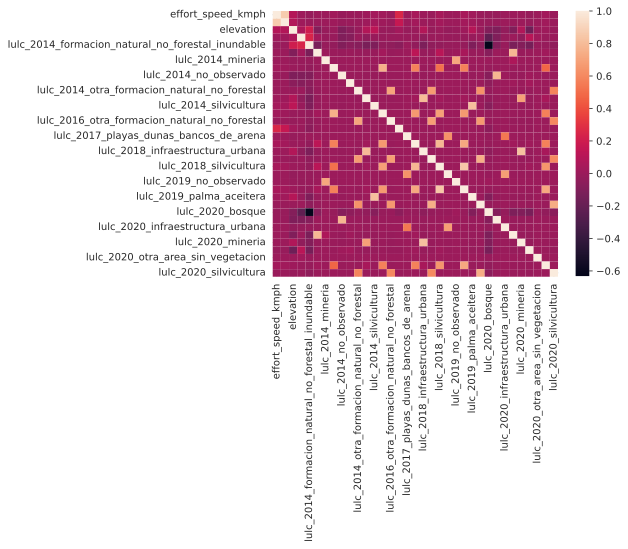

In [58]:
# Matriz de correlación
sns.heatmap(gdf_mb_ev_elv_wc_vu[variables_seleccionadas_final].drop(columns=['geometry','observation_count']).corr(numeric_only=True))

# Displaying heatmap
plt.show()

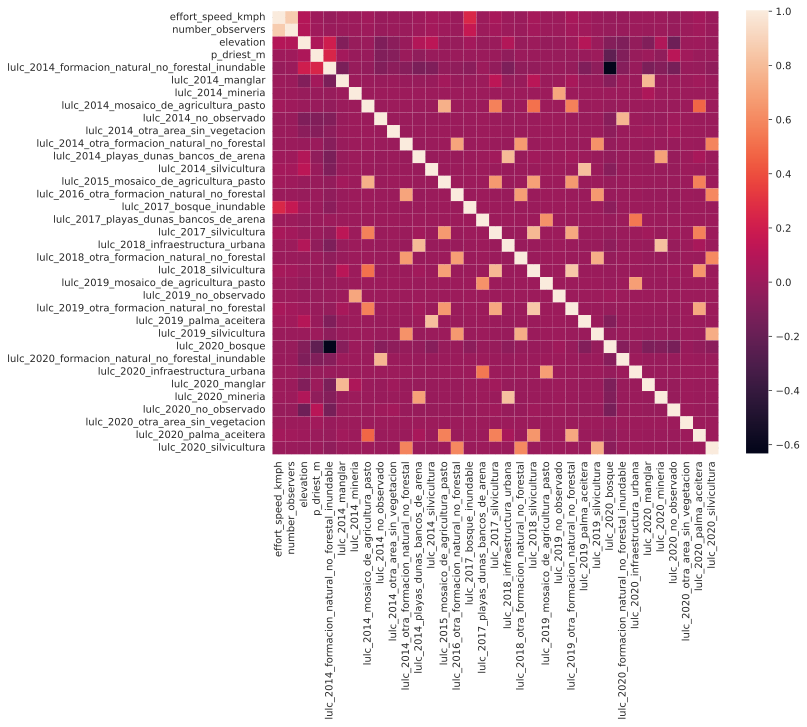

In [59]:
# Crear figura y ejes explícitamente
fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño según lo que necesites

# Crear el heatmap
sns.heatmap(
    gdf_mb_ev_elv_wc_vu[variables_seleccionadas_final].drop(columns=['geometry','observation_count']).corr(numeric_only=True),
    ax=ax
)

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_23_matriz_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [60]:
# Se declara la X e y de nuestro problema
X = gdf_mb_ev_elv_wc_vu[variables_seleccionadas_final]
y = gdf_mb_ev_elv_wc_vu['label']

In [61]:
# Pipeline declaration
pipe_lr = Pipeline([('LR', LogisticRegression(random_state=42))]) # Regresión Logística
pipe_rf = Pipeline([('RF',RandomForestClassifier(random_state=42))]) # Random Forest

In [62]:
# Configuración de los hiper-parámetros del modelo
param_range_fl = [1.0, 0.5, 0.1]
param_range = [1, 2, 3, 4, 5, 6]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                  'LR__C': param_range_fl,
                  'LR__solver': ['liblinear']}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                  'RF__max_depth': param_range,
                  'RF__min_samples_split': param_range[1:]}]

In [63]:
# Configuración de validación cruzada

cv = 3
n_jobs = -1
verbose = 2
random_state = 42

lr_grid_search = RandomizedSearchCV(estimator=pipe_lr,
        param_distributions=lr_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

rf_grid_search = RandomizedSearchCV(estimator=pipe_rf,
        param_distributions=rf_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

### **Prueba sin tratar el desbalance de clases**

In [64]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [65]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(columns=['geometry','observation_count']), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 1.12 s, sys: 193 ms, total: 1.32 s
Wall time: 15.3 s


In [66]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       1.00      0.08      0.14        39

    accuracy                           0.97      1425
   macro avg       0.99      0.54      0.57      1425
weighted avg       0.98      0.97      0.96      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1386
           1       0.88      0.18      0.30        39

    accuracy                           0.98      1425
   macro avg       0.93      0.59      0.64      1425
weighted avg       0.97      0.98      0.97      1425



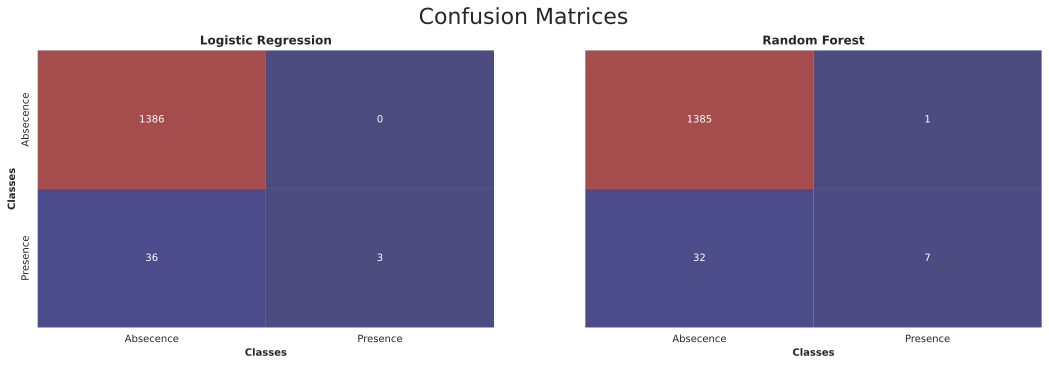

In [67]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Absecence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_40_VU_sin_balanceo_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [68]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr = final_model_lr.predict_proba(X.drop(['geometry','observation_count'],axis=1))
y_final_rf = final_model_rf.predict_proba(X.drop(['geometry','observation_count'],axis=1))


# Almacenamiento de la probabilidad asociada al modelo
X['lr_probability'] = y_final_lr[:,1]
X['rf_probability'] = y_final_rf[:,1]

In [69]:
# MAPS - PROBABILITY
fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(12,9))
axis[0].set_title('Logistic Regression Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[0], markersize=8, column='lr_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[0].add_artist(ScaleBar(1))
plt.grid(False)

axis[1].set_title('Random Forest Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[1], markersize=8, column='rf_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[1].add_artist(ScaleBar(1))
plt.grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_61_MAPA_VU_sin_balanceo_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Prueba balanceando clases: RandomOverSampler**

Los resultados anteriores pueden ser engañosos, por lo que convendría aplicar alguna técnica que permita lidiar con el desbalance de clases:

In [70]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [71]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [72]:
# Conversión a GeoDataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

In [73]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train_resampled.drop(columns=['geometry','observation_count','lr_probability','rf_probability']), y_train_resampled)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 2.09 s, sys: 86.2 ms, total: 2.18 s
Wall time: 14 s


In [74]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l2', 'LR__C': 0.1}

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1386
           1       0.10      0.67      0.17        39

    accuracy                           0.82      1425
   macro avg       0.54      0.74      0.53      1425
weighted avg       0.96      0.82      0.88      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1386
           1       0.23      0.87      0.37        39

    accuracy                           0.92      1425
   macro avg       0.61      0.90      0.66      1425
weighted avg       0.98      0.92      0.94      1425



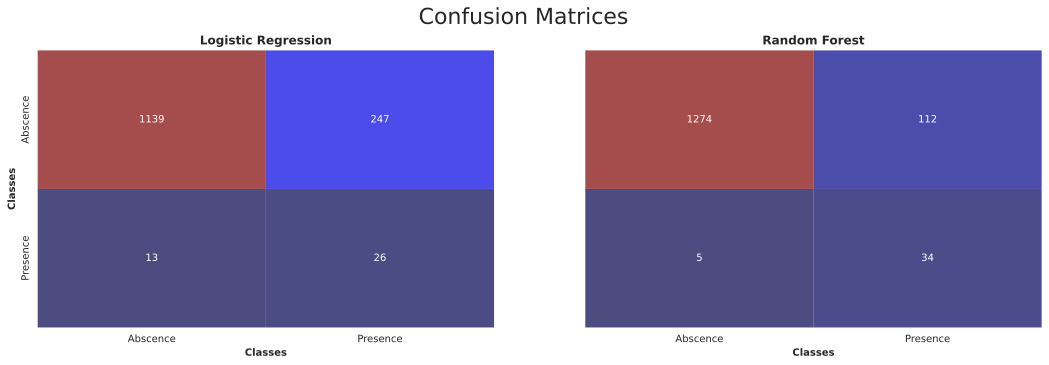

In [75]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search}
iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Abscence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_41_VU_balanceo_RandomOver_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [76]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr_ros = final_model_lr.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability'],axis=1))
y_final_rf_ros = final_model_rf.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['lr_ros_probability'] = y_final_lr_ros[:,1]
X['rf_ros_probability'] = y_final_rf_ros[:,1]

In [77]:
# MAPAS - PROBABILIDAD
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))  # Cambié ncols=1 a ncols=2 para crear dos subplots

# Primer subplot: Probabilidad del modelo de Regresión Logística
axis[0].set_title('LR Oversampling Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg=5382).plot(ax=axis[0], markersize=8, column='lr_ros_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0], crs=X.to_crs(epsg=5382).crs, attribution_size=3)
axis[0].add_artist(ScaleBar(1))
axis[0].grid(False)

# Segundo subplot: Probabilidad del modelo Random Forest
axis[1].set_title('RF Oversampling Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg=5382).plot(ax=axis[1], markersize=8, column='rf_ros_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1], crs=X.to_crs(epsg=5382).crs, attribution_size=3)
axis[1].add_artist(ScaleBar(1))
axis[1].grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_62_MAPA_VU_balanceo_RandomOver_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Prueba balanceando clases: SMOTE - Synthetic Minority Over-sampling Technique**

Otra alternativa para tratar el desbalance es usar la función SMOTE:

In [78]:
# Semilla para garantizar reproducibilidad
random_seed = 42

# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=random_seed)

In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.drop(columns=['geometry']), y_train)

In [80]:
# Conversión a GeoDataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.drop(columns=['geometry']).columns)

In [81]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'Random Forest': rf_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train_resampled.drop(columns=['observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']), y_train_resampled)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
CPU times: user 1.3 s, sys: 68.5 ms, total: 1.37 s
Wall time: 13.6 s


In [82]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns='prediction')

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l2', 'LR__C': 0.1}

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1386
           1       0.10      0.67      0.17        39

    accuracy                           0.83      1425
   macro avg       0.54      0.75      0.54      1425
weighted avg       0.96      0.83      0.88      1425

-------------------------------------------------------------------

Random Forest Best Params: {'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1386
           1       0.29      0.74      0.42        39

    accuracy                           0.94      1425
   macro avg       0.64      0.85      0.69      1425
weighted avg       0.97      0.94      0.95      1425



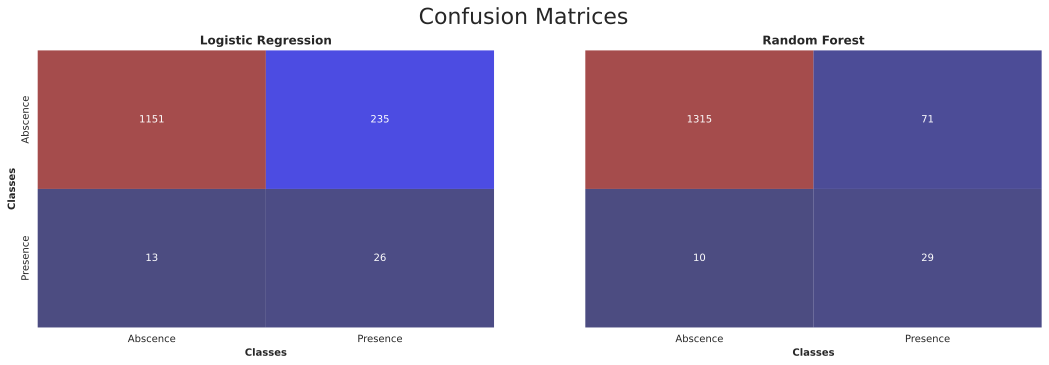

In [83]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Random Forest': rf_grid_search,}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability']))
    # y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Abscence', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_42_VU_balanceo_SMOTE_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

In [84]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model_lr = aux_grid_dict['Logistic Regression'].best_estimator_
final_model_rf = aux_grid_dict['Random Forest'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final_lr_smote = final_model_lr.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability'],axis=1))
y_final_rf_smote = final_model_rf.predict_proba(X.drop(['geometry','observation_count','lr_probability','rf_probability','lr_ros_probability','rf_ros_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['lr_smote_probability'] = y_final_lr_smote[:,1]
X['rf_smote_probability'] = y_final_rf_smote[:,1]

In [85]:
# MAPS - PROBABILITY
fig, axis = plt.subplots(nrows=1, ncols=2,figsize=(12,9))
axis[0].set_title('LR SMOTE Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[0], markersize=8, column='lr_smote_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[0],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[0].add_artist(ScaleBar(1))
plt.grid(False)

axis[1].set_title('RF SMOTE Probability', fontsize=18, fontweight='bold', pad=20)
X.to_crs(epsg = 5382).plot(ax=axis[1], markersize=8, column='rf_smote_probability', cmap='Greens', legend=True, vmin=0, vmax=1, legend_kwds={'shrink': 0.6, 'aspect': 20})
cx.add_basemap(ax=axis[1],crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis[1].add_artist(ScaleBar(1))
plt.grid(False)

plt.tight_layout()

# Guardar la figura en formato PNG con calidad 600 dpi y fondo transparente
fig.savefig(ruta_figs + 'fig_63_MAPA_VU_balanceo_SMOTE_con_VIF.png', dpi=600, bbox_inches='tight', format='png', transparent=True)

# Mostrar la figura
plt.show()

Output hidden; open in https://colab.research.google.com to view.